In [1]:
import pandas as pd
import numpy as np
import statistics
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [2]:
bank_data = pd.read_csv("BankChurners.csv").drop(columns = ['CLIENTNUM'])

In [3]:
bank_data1 = bank_data.replace('Unknown', np.nan)

card_cate_map = {'Blue': 0, 'Silver': 1, 'Gold':2, 'Platinum': 3}
for i in range(len(bank_data1['Card_Category'])):
    for j in card_cate_map:
        if bank_data1['Card_Category'][i] == j:
            bank_data1.at[i, 'Card_Category'] = card_cate_map[j]       

#Transfer education category to integers, because there is a hierarical relationship
education_cate_map = {'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4, 'Doctorate':5 }
for i in range(len(bank_data1['Education_Level'])):
    for j in education_cate_map:
        if bank_data1['Education_Level'][i] == j:
            bank_data1.at[i, 'Education_Level'] = education_cate_map[j]

income_cate_map = { 'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K':3, '$120K +': 4}
for i in range(len(bank_data1['Income_Category'])):
    for j in income_cate_map:
        if bank_data1['Income_Category'][i] == j:
            bank_data1.at[i, 'Income_Category'] = income_cate_map[j]
            
attrition_flag_map = {'Existing Customer': 0, 'Attrited Customer': 1}
for i in range(len(bank_data1['Attrition_Flag'])):
    for j in attrition_flag_map:
        if bank_data1['Attrition_Flag'][i] == j:
            bank_data1.at[i, 'Attrition_Flag'] = attrition_flag_map[j]
            
data1_pd = pd.get_dummies(bank_data1, columns = ['Gender','Marital_Status'])

data1_pd.fillna(data1_pd.mean(), inplace=True)

data1 = data1_pd.to_numpy()

In [4]:
bank_data2 = bank_data

#Transfer card category to integers, because there is a hierarical relationship
card_cate_map = {'Blue': 0, 'Silver': 1, 'Gold':2, 'Platinum': 3}
for i in range(len(bank_data2['Card_Category'])):
    for j in card_cate_map:
        if bank_data2['Card_Category'][i] == j:
            bank_data2.at[i, 'Card_Category'] = card_cate_map[j]       

#Transfer education category to integers, because there is a hierarical relationship
education_cate_map = {'Unknown':np.nan,'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4, 'Doctorate':5 }
for i in range(len(bank_data2['Education_Level'])):
    for j in education_cate_map:
        if bank_data2['Education_Level'][i] == j:
            bank_data2.at[i, 'Education_Level'] = education_cate_map[j]

income_cate_map = {'Unknown': np.nan, 'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K':3, '$120K +': 4}
for i in range(len(bank_data2['Income_Category'])):
    for j in income_cate_map:
        if bank_data2['Income_Category'][i] == j:
            bank_data2.at[i, 'Income_Category'] = income_cate_map[j]
            
attrition_flag_map = {'Existing Customer': 0, 'Attrited Customer': 1}
for i in range(len(bank_data2['Attrition_Flag'])):
    for j in attrition_flag_map:
        if bank_data2['Attrition_Flag'][i] == j:
            bank_data2.at[i, 'Attrition_Flag'] = attrition_flag_map[j]
            
data2_pd = pd.get_dummies(bank_data2, columns = ['Gender','Marital_Status'])
data2_np = data2_pd.to_numpy()

In [5]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data2_np)
IterativeImputer(random_state=0)
data2 = imp_mean.transform(data2_np)

In [6]:
array_sum = np.sum(data2)
array_has_nan = np.isnan(array_sum)
array_has_nan

False

In [7]:
X1 = data1[:, 1:]
y1 = data1[:, 0]

X2 = data2[:, 1:]
y2 = data2[:, 0]

# Use LabelEncoder to transform target values into integers.
label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(y1)
y2 = label_encoder.fit_transform(y2)

In [8]:
# Preprocess the data with the StandardScalar
sc_X = StandardScaler()
X1 = sc_X.fit_transform(X1)
X2 = sc_X.fit_transform(X2)

In [9]:
# Removes highly correlated data
X1 = pd.DataFrame(X1)
cor_matrix1 = X1.corr().abs()
# Select upper triangle of correlation matrix
upper_tri1 = cor_matrix1.where(np.triu(np.ones(cor_matrix1.shape),k=1).astype(bool))
to_drop1 = [column for column in upper_tri1.columns if any(upper_tri1[column] > 0.90)]
print("There are " + str(len(to_drop1)) + " columns to be dropped in the first preprocessing dataset")
X1 = X1.drop(X1.columns[to_drop1], axis = 1)

# Removes highly correlated data
X2 = pd.DataFrame(X2)
cor_matrix2 = X2.corr().abs()
# Select upper triangle of correlation matrix
upper_tri2 = cor_matrix2.where(np.triu(np.ones(cor_matrix2.shape),k=1).astype(bool))
to_drop2 = [column for column in upper_tri2.columns if any(upper_tri2[column] > 0.90)]
print("There are " + str(len(to_drop2)) + " columns to be dropped in the second preprocessing dataset")
X2 = X2.drop(X2.columns[to_drop2], axis = 1)

There are 2 columns to be dropped in the first preprocessing dataset
There are 2 columns to be dropped in the second preprocessing dataset


In [10]:
Xs = [X1, X2]
ys = [y1, y2]

In [11]:
feature_dict={}
high_low_dict = {}
    
def feature_importance(name, model, X, y):
    model.fit(X, y)
    temp_dict={}
    if name == "SVM Linear":
        importance = [abs(model.coef_[0][i]) for i in range(len(model.coef_[0]))]
    else:
        importance = model.feature_importances_
    for i,v in enumerate(importance):
        temp_dict['Feature ' + str(i)] = v
        feature_dict[name + ' Feature'] = temp_dict
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

def high_low_feature(feature_dict):
    final_dict={}
    for i in feature_dict:
        temp_dict={}
        max_key = max(feature_dict[i], key=feature_dict[i].get)
        max_value = max(feature_dict[i].values())
        temp_dict[max_key] = max_value
        final_dict[i] = temp_dict
    print(final_dict)

Using the preprocessing data 1
The model running is: xgboost


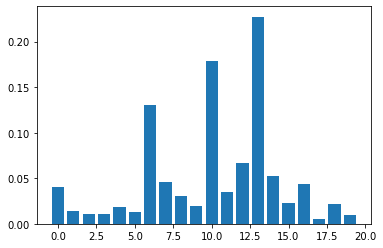

{'xgboost Feature': {'Feature 13': 0.22733772}}
the score is 0.9701785918857324 with std of 0.001916593424974616
auc 0.9698845094786189 got added
the score is 0.9712656453755499 with std of 0.004514224533111744
auc 0.9693380142738808 got added
the score is 0.9727460543794864 with std of 0.001605898223361121
auc 0.9683683033851103 got added
the score is 0.9722521784700133 with std of 0.004343159592051646
auc 0.9704041846233976 got added
the score is 0.9712648166429017 with std of 0.002621349259315263
auc 0.9707071893596853 got added
the score is 0.9712653528816741 with std of 0.004405658615276828
auc 0.9698949665532473 got added
the score is 0.9715614054330738 with std of 0.002174149418968661
auc 0.9683831739325546 got added
the score is 0.9708699499104236 with std of 0.0006983436784085374
auc 0.9716580291954103 got added
the score is 0.9708702424042996 with std of 0.001994775087218743
auc 0.9691209901464889 got added
the score is 0.9711658562148855 with std of 0.0022905076210954682
auc

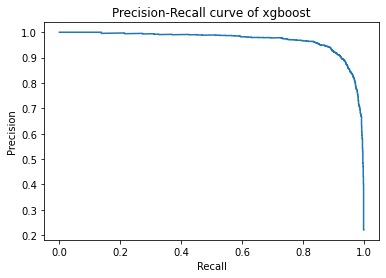


Using the preprocessing data 2
The model running is: xgboost


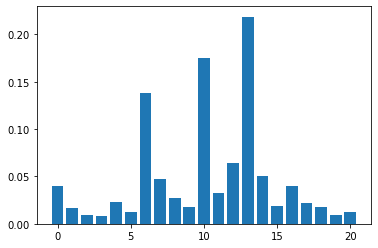

{'xgboost Feature': {'Feature 13': 0.2185927}}
the score is 0.9721543880175009 with std of 0.004362169403030094
auc 0.9708535054813 got added
the score is 0.9720547938527536 with std of 0.0021333904019027
auc 0.9698865591559002 got added
the score is 0.9702770648239554 with std of 0.0029732937981898173
auc 0.969242911385371 got added
the score is 0.9722523247169512 with std of 0.002953674017414317
auc 0.9706438433651269 got added
the score is 0.9707716719681182 with std of 0.0029644187168243095
auc 0.968815827004887 got added
the score is 0.9730427406676172 with std of 0.0026927590532279545
auc 0.9691473557649994 got added
the score is 0.9712655966265705 with std of 0.0037335570742769086
auc 0.9701517604371884 got added
the score is 0.9707711844783251 with std of 0.001832044449232374
auc 0.9696110526781635 got added
the score is 0.9724498555811488 with std of 0.0028171767807646576
auc 0.9704558182623847 got added
the score is 0.9712646216469842 with std of 0.0019892177268565235
auc 0.9

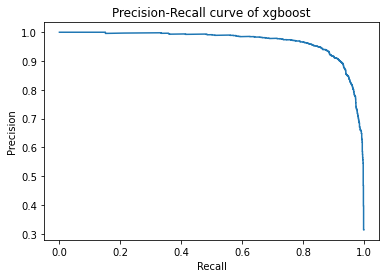

In [12]:
number_repeat = 10 #minimum is 1
scores_list = [{},{}]
aucs = [{},{}]

# define models to train
names = [
#        'Decision Tree',
#          'SVM Linear',
#          'SVM RBF', 
#          'SVM Sigmoid'
#         'BaggingClassifier',
#         'RandomForest',
#         'Adaboost',
            'xgboost'
        ]

# build classifiers
classifiers = [
#     tree.DecisionTreeClassifier(),
#     SVC(kernel='linear', C = 2.0, gamma='scale'),
#     SVC(kernel='rbf', C = 2.0, gamma='scale'),
#     SVC(kernel='sigmoid', C = 2.0, gamma='scale'),
#     BaggingClassifier(n_estimators=200, oob_score = True),
#     RandomForestClassifier(n_estimators=300, max_features = "sqrt", oob_score = True),
#     AdaBoostClassifier(n_estimators=400, learning_rate = 0.6)
     xgb.XGBClassifier(objective="binary:logistic", eval_metric='mlogloss', random_state=42, use_label_encoder=False)
]

models = zip(names, classifiers)

for name, model in models:
    # Use stratified k-fold cross validation to deal with imbalanced data
    for pre_time in range(2):
        print("Using the preprocessing data", pre_time + 1)
        score_dict = scores_list[pre_time]
        auc_dict = aucs[pre_time]
        X = Xs[pre_time]
        y = ys[pre_time]
        
        print("The model running is: " + name)

        if name != "BaggingClassifier":
            feature_importance(name, model, X, y)
        high_low_feature(feature_dict)
        kfold = StratifiedKFold(n_splits=5, shuffle=True)
        for i in range(number_repeat):
            kfold = StratifiedKFold(n_splits=5, shuffle=True)
            scores = cross_val_score(model, X, y, cv = kfold)
            if name not in score_dict:
                score_dict[name] = [] 
            score_dict[name].append((scores.mean(), scores.std()))
            print("the score is", scores.mean(),"with std of", scores.std())
            y_pred = cross_val_predict(model, X, y, cv=kfold, method='predict_proba')[:,1]
            if name not in auc_dict:
                auc_dict[name] = [] 
            precision, recall, thresholds = precision_recall_curve(y, y_pred)
            auc_precision_recall = auc(recall, precision)
            auc_dict[name].append(auc_precision_recall)
            print("auc", auc_precision_recall, "got added")
    
        y_classification = cross_val_predict(model, X, y, cv=kfold)
        y_pred = cross_val_predict(model, X, y, cv=kfold,method='predict_proba')[:,1]
        print(classification_report(y, y_classification))

        confusion_mat = confusion_matrix(y, y_classification)
        graph = pd.DataFrame(confusion_mat, 
                 columns=['Predicted Negative', 'Predicted Positive'], 
                 index=['Actual Negative', 'Actual Positive'])

        print(graph)
        print()
        fn = confusion_mat[1][0]
        tn = confusion_mat[0][0]
        tp = confusion_mat[1][1]
        fp = confusion_mat[0][1] 

        print("The FN is ", fn)
        print("The tn is ", tn)
        print("The tp is ", tp)
        print("The fp is ", fp)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall / (precision + recall))

        print()
        print("The precision is: ", precision)
        print("The recall is: ", recall)
        print("The f1 score is: ", f1_score)

        print('Area under the Receiver Operating Characteristic curve:', str(roc_auc_score(y, y_classification)))
        print()
        auc_precision_recall_mean = sum(auc_dict[name]) / len(auc_dict[name])
        auc_precision_recall_std = statistics.pstdev(auc_dict[name])
        print("The averagve area under the precision-recall curve is:", auc_precision_recall_mean, "with std of", auc_precision_recall_std)
        print()
        temp_list = score_dict[name]
        score_mean = 0
        score_std = 0
        for i in temp_list:
            score_mean += i[0]
            score_std += i[1]
        score_mean /= len(temp_list)
        score_std /= len(temp_list)
        print("The average accuracy is",score_mean,"with the std of",score_std)
        print()
        precision, recall, thresholds = precision_recall_curve(y, y_pred)
        plt.plot(recall, precision)
        plt.title("Precision-Recall curve of " + name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        print()